In [20]:
import pandas as pd
import statsmodels.formula.api as sm
import datetime as dt

In [169]:
SEASONS = {
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'fall': [9, 10, 11],
    'winter': [12, 1, 2],
}

In [170]:
class CO2Predictor:
    def __init__(self, src='./co2.csv'):
        self.main_df = pd.read_csv(src)
        self.__setup_df()
        self.models = {}

    def __setup_df(self):
        dates = []
        for data in self.main_df.values:
            dates.append(dt.datetime.strptime('%04d-%02d'% (data[0], data[1]), '%Y-%m'))
        for season in SEASONS:
            self.main_df.loc[self.main_df['month'].isin(SEASONS[season]), 'season'] = season
        self.main_df.drop(columns=['month_a', 'month', 'trend'], inplace=True)

        self.main_df['time'] = dates
        self.main_df = self.main_df[['time', 'year', 'season', 'average']]

    def create_model(self, formula='average~year', save=True, name='pred'):
        model = sm.ols(formula=formula, data=self.main_df).fit()
        self.models[name] = model
        if save:
            self.main_df[name+'_pred'] = model.predict(self.main_df)
            self.main_df.plot(kind='line', x='time', y=['average', name+'_pred'], ylabel='CO2 (ppm)')

    def plot_model(self, name, x='time'):
        y = ['average', name + '_pred']
        if x != 'time':
            self.main_df.groupby(x, as_index=False).mean().plot(kind='line', x=x, y=y, ylabel='CO2 (ppm)')
        else:
            self.main_df.plot(kind='line', x=x, y=y, ylabel='CO2 (ppm)')

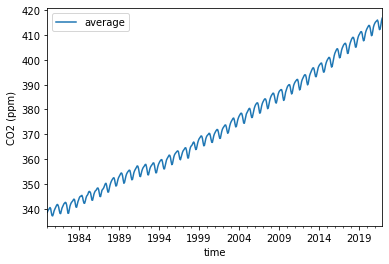

In [171]:
predictor = CO2Predictor()
predictor.main_df.plot(kind='line', x='time', y='average', ylabel='CO2 (ppm)')

In [172]:
predictor.main_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,504.0,2000.500000,12.132961,1980.00,1990.000,2000.500,2011.0000,2021.00
average,504.0,372.555079,22.406417,337.05,354.015,369.855,390.6525,416.76


## Predict $ CO_2 $ with year only
$$ CO_2 = c_0 + c_1 \times year $$

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                average   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 3.779e+04
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:17:41   Log-Likelihood:                -1189.5
No. Observations:                 504   AIC:                             2383.
Df Residuals:                     502   BIC:                             2391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3297.5492     18.880   -174.654      0.000   -3334.644   -3260.455
year           1.8346      0.009    194.390      0.000       1.816       1.853
==============================================================================
Omnibus:                       19.942   Durbin-Watson:                   0.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.009
Skew:                           0.181   Prob(JB):                      0.00407
Kurtosis:                       2.373   Cond. No.                     3.30e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

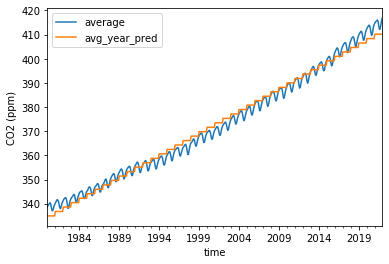

In [173]:
predictor.create_model(formula='average~year', name='avg_year')
predictor.models['avg_year'].summary()

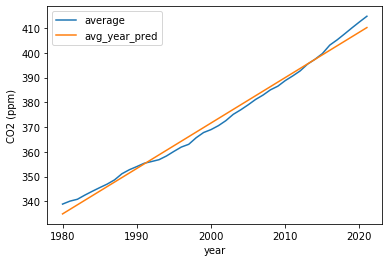

In [174]:
predictor.plot_model(name='avg_year', x='year')

## Predict $ CO_2 $ with $ year,\;year^2 $
$$ CO_2 = c_0 + c_1 \times year^2 $$

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                average   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 6.092e+04
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:17:45   Log-Likelihood:                -896.26
No. Observations:                 504   AIC:                             1799.
Df Residuals:                     501   BIC:                             1811.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.148e+04   1950.607     31.521      0.000    5.77e+04    6.53e+04
year           -62.9335      1.950    -32.271      0.000     -66.765     -59.102
I(year ** 2)     0.0162      0.000     33.212      0.000       0.015       0.017
==============================================================================
Omnibus:                       23.173   Durbin-Watson:                   0.472
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.140
Skew:                          -0.441   Prob(JB):                     2.57e-05
Kurtosis:                       2.521   Cond. No.                     1.22e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

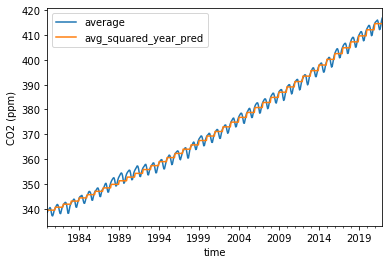

In [175]:
predictor.create_model(formula='average~year+I(year**2)', name='avg_squared_year')
predictor.models['avg_squared_year'].summary()

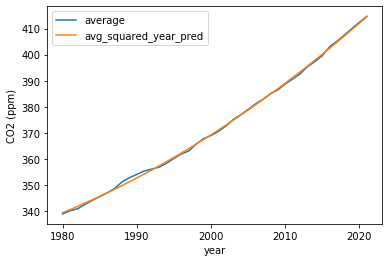

In [176]:
predictor.plot_model('avg_squared_year', 'year')

## Predict $ CO_2 $ with $ year,\;year^2,\;season $
$$ CO_2 = c_0 + c_1 \times year + c_2 \times year^2 + c_3 \times [spring] + \cdots + c_5 \times [winter] $$

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                average   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.380e+04
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:17:48   Log-Likelihood:                -747.48
No. Observations:                 504   AIC:                             1507.
Df Residuals:                     498   BIC:                             1532.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         6.148e+04   1456.354     42.217      0.000    5.86e+04    6.43e+04
season[T.spring]     2.1495      0.135     15.906      0.000       1.884       2.415
season[T.summer]    -0.0333      0.135     -0.247      0.805      -0.299       0.232
season[T.winter]     1.5467      0.135     11.445      0.000       1.281       1.812
year               -62.9335      1.456    -43.223      0.000     -65.794     -60.073
I(year ** 2)         0.0162      0.000     44.483      0.000       0.015       0.017
==============================================================================
Omnibus:                        3.907   Durbin-Watson:                   0.900
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.914
Skew:                           0.187   Prob(JB):                        0.141
Kurtosis:                       2.785   Cond. No.                     1.22e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

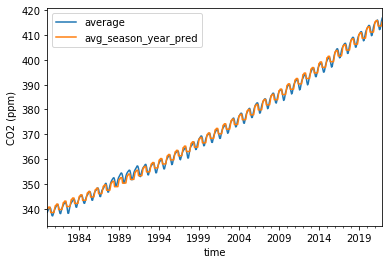

In [177]:
predictor.create_model(formula='average~year+I(year**2)+season', name='avg_season_year')
predictor.models['avg_season_year'].summary()

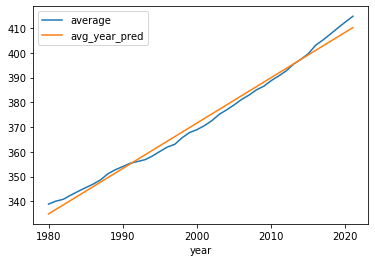

In [178]:
predictor.main_df.groupby('year', as_index=False).mean().plot(kind='line', x='year', y=['average', 'avg_year_pred'])

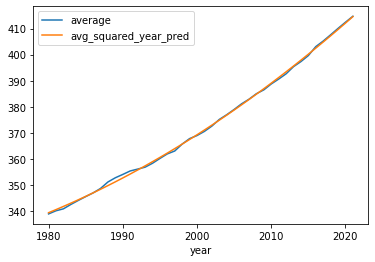

In [179]:
predictor.main_df.groupby('year', as_index=False).mean().plot(kind='line', x='year', y=['average', 'avg_squared_year_pred'])

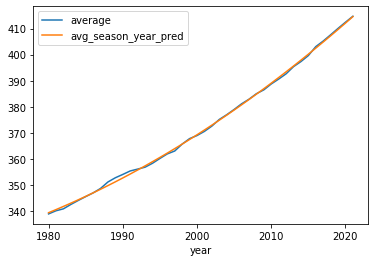

In [180]:
predictor.main_df.groupby('year', as_index=False).mean().plot(kind='line', x='year', y=['average', 'avg_season_year_pred'])